In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

In [2]:
class Plaster:
    def __init__(self, points, plaster_number):
        self.points = points
        self.plaster_number = plaster_number

    def get_num_points(self):
        return len(self.points)

    def interpolate_circle(self):
        if len(self.points) < 3:
            return None, None

        x = self.points["x"]
        y = self.points["y"]
        z = self.points["z"]

        def objective_function(center_radius):
            cx, cy, r = center_radius
            distance = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
            return np.sum((distance - r) ** 2)

        center_radius_guess = [np.mean(x), np.mean(y), np.std(x)]


        result = minimize(objective_function, center_radius_guess, method='Nelder-Mead')
        center = result.x.tolist()
        center.append(np.mean(z))
        radius = result.x[2]
        deviation = np.sqrt(result.fun / len(self.points))

        return deviation, center


In [3]:
class PointCloud:
    def __init__(self, filename):
        self.filename = filename
        self.points = None

    def load_point_cloud(self):
        try:
            point_cloud = laspy.read(self.filename)
            self.points = point_cloud.points
        except Exception as e:
            print(f"Error loading point cloud: {e}")

    def divide_into_plasters(self, num_plasters):
        if self.points is None:
            print("Point cloud not loaded.")
            return []

        min_z = np.min(self.points["z"])
        max_z = np.max(self.points["z"])
        z_range = max_z - min_z
        step_size = z_range / num_plasters

        plasters = []
        for i in range(num_plasters):
            min_z_plaster = min_z + i * step_size
            max_z_plaster = min_z + (i + 1) * step_size
            plaster_points = self.points[(self.points["z"] >= min_z_plaster) & (self.points["z"] < max_z_plaster)]
            plaster = Plaster(plaster_points, i + 1)
            plasters.append(plaster)

        return plasters

In [50]:
# inital 

point_cloud = PointCloud("Komin.las")
point_cloud.load_point_cloud()

num_plasters = 8

plasters = point_cloud.divide_into_plasters(num_plasters)
centers = []
for plaster in plasters:
    deviation, center = plaster.interpolate_circle()
    if deviation is not None:
        centers.append(center)

centers = np.array(centers)

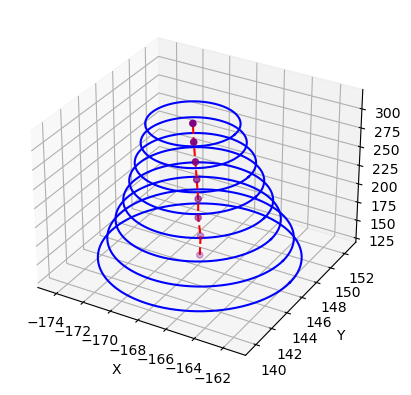

In [63]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for center in centers:
    cx, cy = center[0], center[1]
    radius = center[2]
    cz = center[3] 
    u = np.linspace(0, 2 * np.pi, 100)
    x = cx + np.cos(u) * radius
    y = cy + np.sin(u) * radius
    z = cz * np.ones_like(x)
    ax.plot(x, y, z, 'b-')


ax.scatter(centers[:, 0], centers[:, 1], centers[:, 3], color='purple', marker='o')
ax.plot(centers[:, 0], centers[:, 1], centers[:, 3], 'r--')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

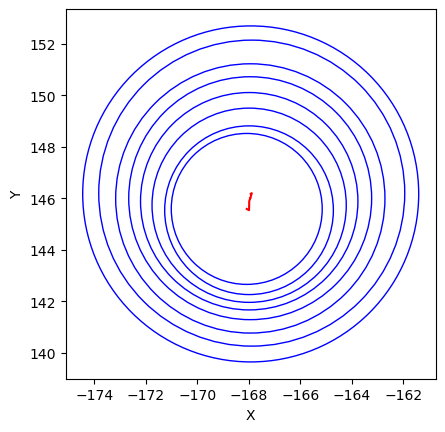

In [53]:
plt.figure()
for center in centers:
    cx, cy = center[0], center[1]
    radius = center[2]
    plt.gca().add_patch(plt.Circle((cx, cy), radius, color='b', fill=False))
plt.plot(centers[:, 0], centers[:, 1], 'r-')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')


plt.show()